In [24]:
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation, Reshape, Input, Embedding, LSTM, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, Model, load_model
from keras.utils  import to_categorical
from datetime     import datetime
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [2]:
data_dir = 'numpy_arrays'
X  = 'train_picture_features.npy'
y  = 'train_picture_labels.npy'

train_features = np.load(os.path.join(data_dir, X))
train_labels   = np.load(os.path.join(data_dir, y))

print("Features:",train_features.shape)
print("Labels", train_labels.shape)

Features: (33402,)
Labels (33402,)


In [3]:
# Preprocessing features
from skimage.transform import resize

%matplotlib inline

def resize_images(arrays, side_length):
    
    array_count = arrays.shape[0]
    template    = np.zeros((side_length, side_length,3))
    all_arrays = []
    
    for array in arrays:
        
        #print(array.shape)
        height, width = array.shape[0], array.shape[1]
        if height > width:
            new_height = side_length
            diff       = side_length / height
            new_width  = width * diff
        else:
            new_width  = side_length
            diff       = side_length / width
            new_height = height * diff
            
            tmp            = resize(array, (int(new_height), int(new_width), 3), mode='constant')
            top_padding    = np.zeros((int((side_length - tmp.shape[0]) / 2), side_length, 3))
            bottom_padding = np.zeros((int(side_length - top_padding.shape[0] - tmp.shape[0]) , side_length, 3))
 
            #print(top_padding.shape)
            #print(tmp.shape)
            #print(bottom_padding.shape)
            final = np.concatenate((top_padding, tmp, bottom_padding))
            #print(final.shape)
        
        all_arrays.append(final)
    
    return np.array(all_arrays)

def crop(arrays, new_width):
    ratio_max = 0.0
    ratio_min = np.inf
    
    for i, array in enumerate(arrays):
        print(array.shape)
        if i > 20:
            break
        height, width = array.shape[0], array.shape[1]
        ratio = height / (1.0 * width)
        ratio_max = max(ratio_max, ratio)
        ratio_min = min(ratio_min, ratio)

    print("MAX: ", ratio_max)
    print("MIN: ", ratio_min)
#################################

def resize_32x32(features):
    return np.array([resize(f, (32, 32, 3), mode='constant') for f in features])

def resize_32x32_grey(features):
    return np.array([resize(f, (32, 32, 1), mode='constant') for f in features])

def resize_64x64(features):
    return np.array([resize(f, (64, 64, 3), mode='constant') for f in features])

resized_images = resize_32x32(train_features)

print(resized_images.shape)
print(type(resized_images))

(33402, 32, 32, 3)
<class 'numpy.ndarray'>


In [4]:
# Preprocessing targets

def list_to_arrays(labels):
    return np.array([np.array(label) for label in labels])

def remove_val(labels, in_val, out_val):
    for label in labels:
        label[label == in_val] = out_val
    
    return labels
    #return np.where(labels==in_val, out_val, labels) 

def pad_labels(train_labels):
    print(train_labels.shape)
    max_len = 0
    
    for arr in train_labels:
        max_len = max(len(arr), max_len)

    print("MAX LENGTH: {}".format(max_len))
    
    return np.array([arr + ((max_len - len(arr)) * [10.0]) for arr in train_labels])     

def one_hot_encoding(labels):
    return np.array([ to_categorical(label, num_classes=11) for label in labels])


train_labels[24] = [6.0, 0.0, 1.0]
print(train_labels[24])
print(train_labels.shape)

padded_labels = pad_labels(train_labels)
print(padded_labels[24])
print(padded_labels.shape)

encoded_labels = one_hot_encoding(padded_labels)
print(encoded_labels[24])
print(encoded_labels.shape)

[6.0, 0.0, 1.0]
(33402,)
(33402,)
MAX LENGTH: 6
[  6.   0.   1.  10.  10.  10.]
(33402, 6)
[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]
(33402, 6, 11)


In [37]:
#encoded_labels[:, 6]
tmp = [encoded_labels[:, i] for i in range(encoded_labels.shape[1])]
type(tmp)

#print(padded_labels[0])
#print(encoded_labels[0])
#print(padded_labels[1])
#print(encoded_labels[1])

#tmp = [label[j] for label in encoded_labels for j in range(len(label))]
reordered_array = []
for i in range(encoded_labels.shape[1]):
    tmp = []

    for label in encoded_labels:
        #print(label[i])

        tmp.append(label[i])
    tmp = np.array(tmp)
    reordered_array.append(tmp)
reordered_array = np.array(reordered_array)

print(reordered_array.shape)
tmp = np.array([i for i in reordered_array])
print(tmp.shape)

(6, 33402, 11)
(200412, 11)


In [84]:
features = resized_images
targets = encoded_labels
#targets = padded_labels
#targets = reordered_array

print("INPUT SHAPE: {}".format(features.shape))
print("OUTPUT SHAPE: {}".format(targets.shape))

#inputs_ = Input(shape=(3,))
inputs_ = Input(shape=(32,32,3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs_)
x = MaxPooling2D(pool_size=(2, 2))(x) 
x = Dropout(0.25)(x)

x = Flatten()(x)

x = Dense(512, activation='relu')(x)

digit1 = Dense(11, activation='softmax')(x)
digit2 = Dense(11, activation='softmax')(x)
digit3 = Dense(11, activation='softmax')(x)
digit4 = Dense(11, activation='softmax')(x)
digit5 = Dense(11, activation='softmax')(x)
digit6 = Dense(11, activation='softmax')(x)



model = Model(inputs=inputs_, outputs=[digit1, digit2, digit3, digit4, digit5, digit6])
model.summary()

INPUT SHAPE: (33402, 32, 32, 3)
OUTPUT SHAPE: (33402, 6, 11)


TypeError: Output tensors to a Model must be Keras tensors. Found: <keras.layers.merge.Concatenate object at 0x7f07997d7f28>

In [81]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

from keras.callbacks import ModelCheckpoint

epochs     = 2
time_now   = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = os.path.join('models', 'model_multi_ModelAPI_' + str(epochs) + 'epochs_' + time_now +'.hdf5')

print("MODEL FILE: {}".format(model_path))

checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, save_best_only=True, monitor='acc',)

model.fit(features, targets
          , epochs=epochs, 
          batch_size=20, 
          callbacks=[checkpointer], 
          verbose=1)


MODEL FILE: models/model_multi_ModelAPI_2epochs_20190701_174630.hdf5


ValueError: The model expects 6 input arrays, but only received one array. Found: array with shape (33402, 6, 11)

6229222261
19
[6, 2, 2, 9, 2, 2, 2, 2, 6, 1] [1.0, 9.0]
3363336336
23
[3, 3, 6, 3, 3, 3, 6, 3, 3, 6] [2.0, 3.0]
919
25
[10, 10, 9, 10, 10, 10, 10, 1, 9, 10] [2.0, 5.0]

93
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10] [9.0, 3.0]

31
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10] [3.0, 1.0]

33
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10] [3.0, 3.0]


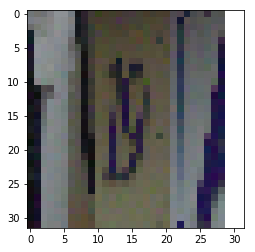

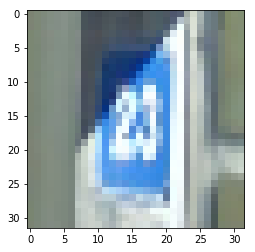

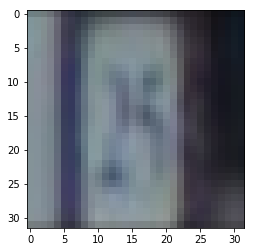

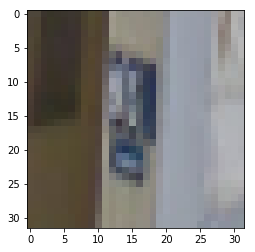

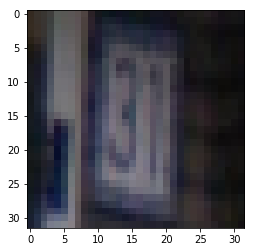

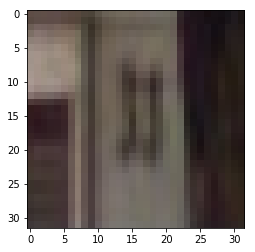

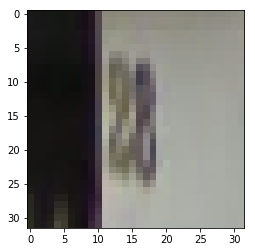

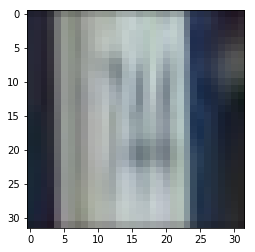

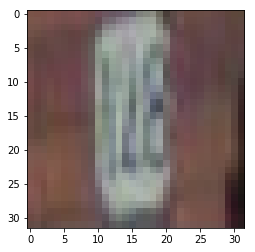

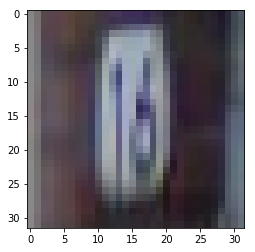

In [34]:
def predict(array_set):
    y_pred      = model.predict(array_set)
    all_preds   = []
    for pred_label in y_pred:
        int_array = [np.argmax(i) for i in pred_label]
        all_preds.append(int_array)
        #print(int_array)
    return all_preds

def get_accuracy(predictions, labels):
    correct = 0
    for i, pred in enumerate(predictions):
        pred_str  = "".join([str(p) for p in pred if p != 10])
        label_str = "".join([str(int(j)) for j in labels[i]])
        #print(pred_str, label_str)
        if pred_str == label_str:
            correct += 1
    return (correct*1.0) / len(predictions)
    
test_set    = resized_images[:10]
predictions = predict(test_set)

for i, pred in enumerate(predictions):
    pred_str  = "".join([str(p) for p in pred if p != 10])
    label_str = "".join([str(int(j)) for j in train_labels[i]])
#    if pred_str == label_str:
#        print("MATCH")
    print(pred_str)
    print(label_str)
    print(pred, train_labels[i])

for img in test_set:
    fig,ax  = plt.subplots(1)
    ax.imshow(img)

In [ ]:
# Testing
test_features = np.load(os.path.join(data_dir, 'test_picture_features.npy'))
test_labels   = np.load(os.path.join(data_dir, 'test_picture_labels.npy'))

In [ ]:
resized_test_images = resize_32x32(test_features)

In [15]:
test_predictions = predict(resized_test_images)

In [20]:
print("Accuracy: {}".format(get_accuracy(test_predictions, test_labels)*100))

Accuracy: 17.77624732170187


In [19]:
def predict_model(model, test_array):
    model     = load_model(model)
    y_pred    = model.predict(array_set)
    all_preds = []
    for pred_label in y_pred:
        int_array = [np.argmax(i) for i in pred_label]
        all_preds.append(int_array)
    return model, all_preds